<a href="https://colab.research.google.com/github/hrithikpurwar/ML/blob/main/DeepLizard2%5BCNN_Image_Basics%2C_Transfer_Learn10_16%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### <B>Image Preparation For A CNN

In [2]:
# Organize data into train, valid, test dirs
os.chdir('/content/drive/MyDrive/Datasets/cat vs dog') #change directory
if os.path.isdir('/content/drive/MyDrive/Datasets/cat vs dog/train/dog') is False: #if train/dog does not already exist, then:
  #make sub directories
    os.makedirs('/content/drive/MyDrive/Datasets/cat vs dog/train/dog')
    os.makedirs('/content/drive/MyDrive/Datasets/cat vs dog/train/cat')
    os.makedirs('/content/drive/MyDrive/Datasets/cat vs dog/valid/dog')
    os.makedirs('/content/drive/MyDrive/Datasets/cat vs dog/valid/cat')
    os.makedirs('/content/drive/MyDrive/Datasets/cat vs dog/test/dog')
    os.makedirs('/content/drive/MyDrive/Datasets/cat vs dog/test/cat')
#(select random subsets of images and move in subdirectories)
#we identify label by name of the file thats why we used glob
  #1000 in train set
    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, '/content/drive/MyDrive/Datasets/cat vs dog/train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, '/content/drive/MyDrive/Datasets/cat vs dog/train/dog')
  #200 in valid set
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, '/content/drive/MyDrive/Datasets/cat vs dog/valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, '/content/drive/MyDrive/Datasets/cat vs dog/valid/dog')
  #100 in test set
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, '/content/drive/MyDrive/Datasets/cat vs dog/test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, '/content/drive/MyDrive/Datasets/cat vs dog/test/dog')

os.chdir('../../')

In [3]:
#gpu check
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
#setting up paths to reduce redundancy in code
train_path = '/content/drive/MyDrive/Datasets/cat vs dog/train'
valid_path = '/content/drive/MyDrive/Datasets/cat vs dog/valid'
test_path = '/content/drive/MyDrive/Datasets/cat vs dog/test'

In [5]:
#create batches of data, in a format, readable by sequential model
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)
#only for test batches, shuffle = false because we need to predict and view confusion matrix and for that we need to access unshuffled labels

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
#grab a single batch of images from train batches
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

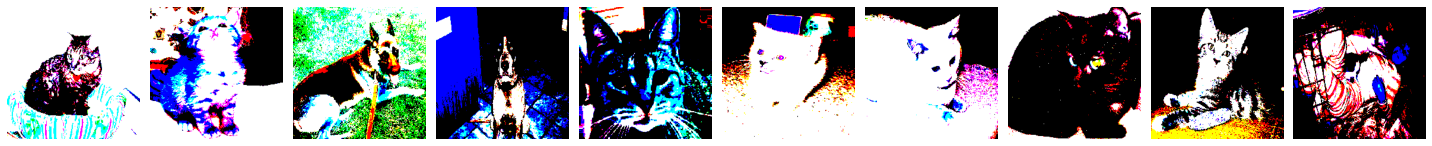

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)
print(labels)

### <B> Build And Train A CNN

In [8]:
## input(24x24x3)->conv layer(32 filters, kernel(multiplying matrix) = 3x3), 0 padding
# -> max pool , pool size 2x2, stride size =2 -> conv layer, 64, kernel =3x3, 0 padding
#-> max pool , 2x2, stride =2 -> 1D vector/tensor 
#padding = valid(no padding) , same(will pad 0 so than input size=output size)
#max-pool layer, filter size=2x2, stride size=2, no padding - 2D bcoz i/p is 2D
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 303s - loss: 18.4702 - accuracy: 0.5640 - val_loss: 18.8417 - val_accuracy: 0.5550
Epoch 2/10
100/100 - 7s - loss: 4.2160 - accuracy: 0.7130 - val_loss: 4.1210 - val_accuracy: 0.5150
Epoch 3/10
100/100 - 7s - loss: 0.8936 - accuracy: 0.8580 - val_loss: 3.8368 - val_accuracy: 0.5650
Epoch 4/10
100/100 - 7s - loss: 0.2380 - accuracy: 0.9420 - val_loss: 3.0570 - val_accuracy: 0.5600
Epoch 5/10
100/100 - 7s - loss: 0.0606 - accuracy: 0.9820 - val_loss: 2.9173 - val_accuracy: 0.5600
Epoch 6/10
100/100 - 7s - loss: 0.0132 - accuracy: 0.9940 - val_loss: 2.8344 - val_accuracy: 0.5650
Epoch 7/10
100/100 - 7s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.7629 - val_accuracy: 0.6000
Epoch 8/10
100/100 - 7s - loss: 6.4559e-04 - accuracy: 1.0000 - val_loss: 2.7567 - val_accuracy: 0.5950
Epoch 9/10
100/100 - 7s - loss: 4.6089e-04 - accuracy: 1.0000 - val_loss: 2.7475 - val_accuracy: 0.5850
Epoch 10/10
100/100 - 7s - loss: 3.9013e-04 - accuracy: 1.0000 - val_loss: 2.7604 - val_

train acc = 100
test acc = 57
Overfitting

### <B> CNN Predictions

In [12]:
#get a batch of test batches
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

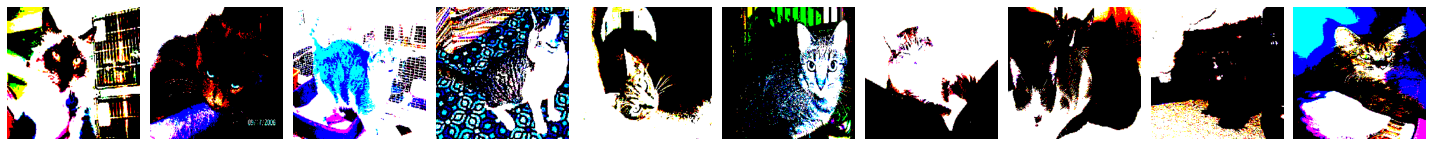

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
#plot test batch of 10 using the same plot func defined above
plotImages(test_imgs)
print(test_labels)

In [14]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=2)

10/10 - 21s


In [15]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [16]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [17]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[30 20]
 [17 33]]


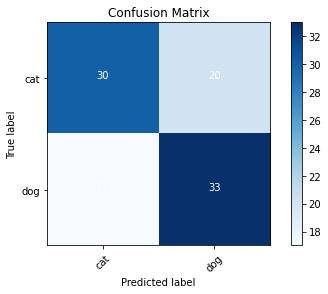

In [20]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# <B> Transfer Learning

### <B> Build A Fine-Tuned VGG 16

## VGG 19 is trained to predict a lot of categories and it also includes cat and dog. So we just remove output layer of existing layer and add new output layer with 2 nodes cat/dog

In [21]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 6s 0us/step


In [22]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
type(vgg16_model)

keras.engine.functional.Functional

In [24]:
#new model with all layers of VGG except output
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [25]:
#freeze weights and biases of all the layers
#no retraining, already learnt
for layer in model.layers:
    layer.trainable = False

In [26]:
#adding own output layer, 2 output classes
model.add(Dense(units=2, activation='softmax'))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

### <B> Train VGG 19 on new output layer

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

Epoch 1/5
100/100 - 19s - loss: 0.2716 - accuracy: 0.8860 - val_loss: 0.1537 - val_accuracy: 0.9550
Epoch 2/5
100/100 - 14s - loss: 0.0871 - accuracy: 0.9660 - val_loss: 0.1309 - val_accuracy: 0.9600
Epoch 3/5
100/100 - 15s - loss: 0.0562 - accuracy: 0.9760 - val_loss: 0.1242 - val_accuracy: 0.9500
Epoch 4/5
100/100 - 15s - loss: 0.0402 - accuracy: 0.9870 - val_loss: 0.1169 - val_accuracy: 0.9600
Epoch 5/5
100/100 - 15s - loss: 0.0309 - accuracy: 0.9920 - val_loss: 0.1240 - val_accuracy: 0.9450


train accuracy = 99.2<br>
test accuracy = 94.5<br>
good model!!




### <b> Predict With A Fine-Tuned VGG19

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

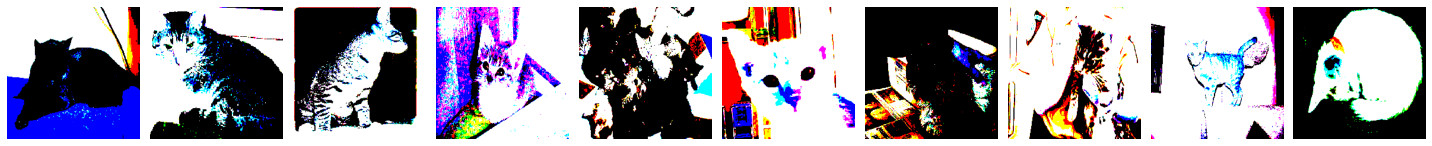

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [30]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [31]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [33]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[47  3]
 [ 0 50]]


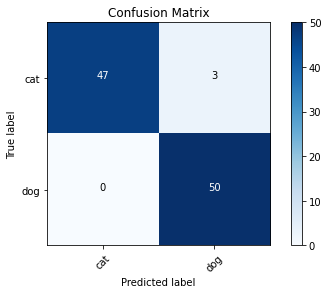

In [32]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')